**NOTE: The project makes use of BERT for a limited subsample of the data.**

## Content <a id='content'></a>

[Introduction](#intro)

[Data overview and preprocessing](#prep)

[ML](#ml)

[Summary and conclusions](#conclusions)

## Introduction <a id='intro'></a>

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We will be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to reach an F1 score of at least 0.85.

To implement the work we will:

1. Load the data and perform basic reprocessing, if required.
2. Conduct an EDA and make your conclusion on the class imbalance.
3. Preprocess the data for modeling.
4. Train at least three different models for the given train dataset.
5. Test the models for the given test dataset.
6. Compose a few of our own reviews and classify them with all the models.
7. Check for differences between the testing results of models in the above two points. Try to explain them.

[Back to Content](#content)

## Data overview and preprocessing <a id='prep'></a>

The data is stored in `the imdb_reviews.tsv` file. Selected fields incllude:
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

*The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).*

Let's load the data.

In [1]:
# Libraries
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Data upload and basic preprocessing

As part of the uploading we will check memory usage and date types for a small subsample, to avoid any excessive use of the memory. We will use a `load()` function to avoid potential problems with the file pathes.

In [2]:
# function `load` for a csv load with try-except and a number of rows limit and `usecols` parameter
def load(filename, sep = ',', usecols = None, nrow = None, dtype = None, parse_dates = None):
    """
    i=In addition to the file name, the function takes nrows parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        if usecols:
            df_raw = pd.read_csv(filename, sep = sep, usecols = usecols,
                                 nrows = nrow, dtype = dtype, parse_dates = parse_dates)
        else:
            df_raw = pd.read_csv(filename, sep = sep, nrows = nrow, dtype = dtype, parse_dates = parse_dates)
    except:
        if usecols:
            df_raw = pd.read_csv('/'+filename, sep = sep, usecols = usecols,
                                 nrows = nrow, dtype = dtype, parse_dates = parse_dates)
        else:
            df_raw = pd.read_csv('/'+filename, sep = sep, nrows = nrow, dtype = dtype, parse_dates = parse_dates)
    return df_raw

In [3]:
# check the dataset data types and memory usage on the first 500 rows
data_raw = load('datasets/imdb_reviews.tsv', sep='\t', nrow = 500)

In [4]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           500 non-null    object 
 1   title_type       500 non-null    object 
 2   primary_title    500 non-null    object 
 3   original_title   500 non-null    object 
 4   start_year       500 non-null    int64  
 5   end_year         500 non-null    object 
 6   runtime_minutes  500 non-null    object 
 7   is_adult         500 non-null    int64  
 8   genres           500 non-null    object 
 9   average_rating   500 non-null    float64
 10  votes            500 non-null    int64  
 11  review           500 non-null    object 
 12  rating           500 non-null    int64  
 13  sp               500 non-null    object 
 14  pos              500 non-null    int64  
 15  ds_part          500 non-null    object 
 16  idx              500 non-null    int64  
dtypes: float64(1), i

In [5]:
data_raw.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


The dataset is memory-consuming, while we only need the three columns mentioned above and presumably some IDs for movies and reviews themselves.

In [6]:
# check the dataset data types and memory usage on the first 500 rows and the required columns
data_raw = load('datasets/imdb_reviews.tsv', sep='\t', usecols = [0, 11, 14, 15, 16], nrow = 500)

In [7]:
data_raw.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tconst   500 non-null    object
 1   review   500 non-null    object
 2   pos      500 non-null    int64 
 3   ds_part  500 non-null    object
 4   idx      500 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 776.4 KB


Great, we have limited the required subset of columns, though the dataset is still memory-consuming, since the `review` variable supposedly contains large string values. Let's upload the whole dataset:

In [8]:
data_raw = load('datasets/imdb_reviews.tsv', sep='\t', usecols = [0, 11, 14, 15, 16])

In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tconst   47331 non-null  object
 1   review   47331 non-null  object
 2   pos      47331 non-null  int64 
 3   ds_part  47331 non-null  object
 4   idx      47331 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [10]:
data_raw['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

In [11]:
# Check for duplicates
data_raw.duplicated().sum()

0

Thus, we have 47331 observations which are divided in equal parts into train and test subsets, no missing values, no duplicates, correct column names.

### EDA

Firtst, let's check how balanced are the two classes:

In [12]:
data_raw['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

OK, the classes are balanced; thus, even the accuracy score will result in relevant quality estimate.

Let's check how the movies in the train and the test data subsets are distributed by the number of positive and negative reviews.

In [13]:
dft = data_raw.groupby(['tconst', 'pos', 'ds_part'])['review'].count().reset_index()

In [14]:
dft

,tconst,pos,ds_part,review
0,tt0000010,1,train,11
1,tt0000030,1,test,1
2,tt0000208,1,test,4
3,tt0000399,0,test,1
4,tt0000430,1,test,1
...,...,...,...,...
8228,tt0996396,1,train,3
8229,tt0997057,0,test,3
8230,tt0997143,0,test,14
8231,tt0997143,1,test,4


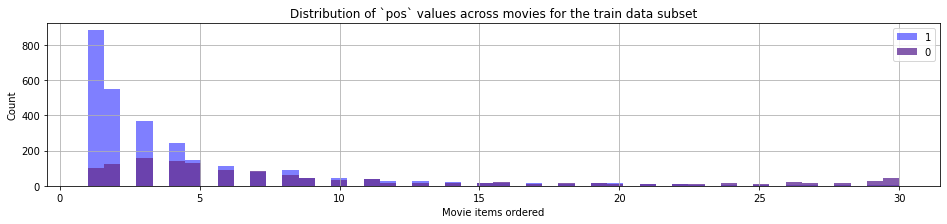

In [15]:
plt.figure(figsize=(16, 3))

dft[(dft['ds_part']=='train') & (dft['pos']==0)]['review'].hist(color = "blue", bins = 50,alpha = 0.5)
dft[(dft['ds_part']=='train') & (dft['pos']==1)]['review'].hist(color = "rebeccapurple",
                                                                    bins = 50, alpha = 0.8)
plt.title('Distribution of `pos` values across movies for the train data subset')
plt.xlabel('Movie items ordered')
plt.ylabel('Count')
plt.legend(['1', '0'])
plt.show()

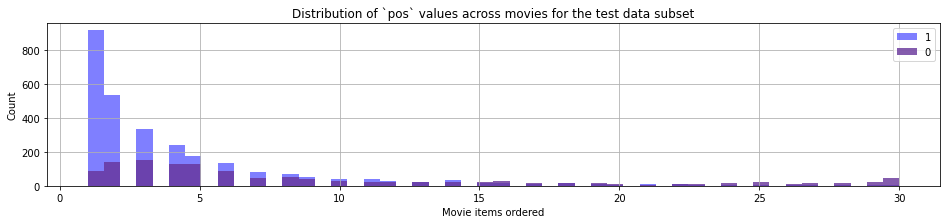

In [16]:
plt.figure(figsize=(16, 3))

dft[(dft['ds_part']=='test') & (dft['pos']==0)]['review'].hist(color = "blue", bins = 50, alpha = 0.5)
dft[(dft['ds_part']=='test') & (dft['pos']==1)]['review'].hist(color = "rebeccapurple",
                                                                    bins = 50, alpha = 0.8)
plt.title('Distribution of `pos` values across movies for the test data subset')
plt.xlabel('Movie items ordered')
plt.ylabel('Count')
plt.legend(['1', '0'])
plt.show()

Distributions of positive and negative reviews look similar for the train and the test data subsets.

NOTE: one can further explore the similarity of the two subsets by evaluationg the distributions of the numbers of reviews across years and reviews per movie. We will proceed with the assumption that the train and the test data subsets come from the same population.

### Data preprocessing for modeling - clear text

To proceed with the modeling we need to clean the data from digits, punctuations marks, etc.; we well also normalize it to lower case. To this end, we will define the `clear_text()` function.

In [17]:
import re

def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = " ".join(text.split())
    text = text.lower()
    
    return text

In [18]:
data = data_raw.copy()

In [19]:
data['review'] = data['review'].apply(lambda x: clear_text(x))

In [20]:
data.head()

,tconst,review,pos,ds_part,idx
0,tt0068152,the pakage implies that warren beatty and gold...,0,train,8335
1,tt0068152,how the hell did they get this made presenting...,0,train,8336
2,tt0313150,there is no real story the film seems more lik...,0,test,2489
3,tt0313150,um a serious film about troubled teens in sing...,1,test,9280
4,tt0313150,i'm totally agree with garryjohal from singapo...,1,test,9281


The whole dataset is already divided into train/test one parts, we just need to single out the target variable:

In [21]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

train_target = data_train['pos']
test_target = data_test['pos']

print(data_train.shape)
print(data_test.shape)

(23796, 5)
(23535, 5)


### Data upload and preprocessing - intermediate summary

1. We have uploaded the relevant subset of the source data and have 47331 observations which are equally divided into train and test subsets; no missing values, no duplicates, correct column names.
2. The distributions of the target variable are similar for the two subsets.
3. We have cleaned the `review` column from digits, punctuation and other signs, and transformed the column into lower case.

[Back to Content](#content)

## Modeling <a id='ml'></a>

###  Evaluation Procedure

For basic evaluation, we will apply the `cross_val_score()` function.

In [22]:
from sklearn.model_selection import cross_val_score

To evaluate the final model we will use the `evaluate_model()` function, which, beside the recommended F1 score, will include accuracy, precision, and recall metrics, as well as will present them through F1, ROC, and PRC curves.

In [23]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['Average Precision Score'] = aps
        
        # Recall
        rs = metrics.recall_score(target, pred_target)
        eval_stats[type]['Recall'] = rs
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='upper center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, APS={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'Average Precision Score', 'Recall', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Baseline

#### Bag-of-words, nltk, Stopwords

As a basic approach, we can apply modeling procedures to the `review` variable vectorized with the basic version of the "bag-of-word" method. This means we're going to transform our texts from word sequences to feature vectors. In `Scikit-learn`, we can construct these raw feature vectors with the `CountVectorizer`, which tokenizes a text and counts the number of times any given text contains every token in the corpus. One peculiarity should be taken into account at this step: usually conjunctions and prepositions are jumbled up; a prefered way is to drop them, since it can be done without loosing the meaning of the sentence. Thus, we will end up with a smaller and cleaner bag-of-words, with a higher share of words important for text classification.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier

We need to download the package once to make it work:

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zheni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We should call the `stopwords.words()` function and use `'english'` as an argument to get a set of stop words for English:

In [26]:
stop_words = set(stopwords.words('english'))

Now, we will create the counter and pass the stop word list to the `CountVectorizer()` when you create the counter:

In [27]:
count_vect = CountVectorizer(stop_words=stop_words)

Now, let's apply the `fit_transform()` method to the `review` column of the `data` dataframe:

In [28]:
bag_of_words_train = count_vect.fit_transform(data_train['review'])

In [29]:
bag_of_words_train

<23796x71531 sparse matrix of type '<class 'numpy.int64'>'
	with 2332924 stored elements in Compressed Sparse Row format>

We received a "bag", effectively a feature matrix, with the same number of rows (observations), 23796, and 71531 individual words in it. Note: for the whole dataset the number of the tokens (words) in the bag would be higher, but we can train our model only using the train subset.

In [30]:
bag_of_words_test = count_vect.transform(data_test['review'])

In [31]:
bag_of_words_test

<23535x71531 sparse matrix of type '<class 'numpy.int64'>'
	with 2215241 stored elements in Compressed Sparse Row format>

#### Dummy Classifier

Before we proceed, let's establish a [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) model. Note: DummyClassifier does not look at the features at all (it just implements some very basic strategies using only train set targets).

In [32]:
dummy_classifier = DummyClassifier(random_state = 54321)  # default strategy='prior', returns the most frequent class label

In [33]:
print("Training the dummy classifier...")
dummy_classifier.fit(bag_of_words_train, train_target)

Training the dummy classifier...


DummyClassifier(random_state=54321)

Let's try and evaluate this model. Note: A dummy classifier make a random prediction in 

In [34]:
scores_dummy = cross_val_score(dummy_classifier,  bag_of_words_train, train_target, cv=5, scoring = 'f1')

In [35]:
scores_dummy

array([0., 0., 0., 0., 0.])

As expected, F1 equals zero, which means zero true (actually predicted) positives.

Let's proceed to a basic non-dummy model.

### Logistic Regression

#### Bag-of-words, nltk, Stopwords, TF-IDF, Logistic Regression

Actually, raw word counts are not very informative: the feature vectors of most texts in the same language will be very similar, while what we are interested in words which distinguish a positive review from a negative the most, i.e. possess the most meaning: words that occur often in positive reviews are expected to occur less often in the corpus, in general, and in the negative reviews, in particular, and vice versa. To assign more weight to these more meaningful words, we can use the [TF-IDF score](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which counts the number of times every token appears in a text and divides it by (the logarithm of) the percentage of corpus documents that contain that token. This weighting is performed by Scikit-learn's `TfidfTransformer`. To obtain the weighted feature vectors, we combine the `CountVectorizer` and `TfidfTransformer` in a `Pipeline`, and fit this pipeline on the training data. We then transform both the training texts and the test texts to a collection of such weighted feature vectors. Scikit-learn also has a `TfidfVectorizer`, which achieves the same result as our pipeline.

As to classification itself, we will apply the basic `LogisticClassifier()` for binary classification. Note: in `LogisticClassifier()` regularization is applied by default; we will use the `C` parameter of the classifier, a positive float for inverse of regularization strength, as the hyperparameter for tuning later on.

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [37]:
preprocessing = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer())
])
  
print("Preprocessing training data...")
train_preprocessed = preprocessing.fit_transform(data_train['review'])

print("Preprocessing test data...")
test_preprocessed = preprocessing.transform(data_test['review'])

Preprocessing training data...
Preprocessing test data...


Let's apply the logistic regression model to unweighted vectorized text data:

In [38]:
lr_classifier = LogisticRegression(random_state=54321, solver = 'liblinear')
scores_lr_classifier = cross_val_score(lr_classifier,  bag_of_words_train, train_target, cv=5, scoring = 'f1')

In [39]:
scores_lr_classifier

array([0.86802778, 0.84821044, 0.84712838, 0.83695189, 0.8484718 ])

In [40]:
scores_lr_classifier.mean()

0.8497580591321408

OK, we have a baseline F1 score of 0.84976. Now, let's apply it to weighted vectorized text data:

In [41]:
lr_classifier_tf_idf = LogisticRegression(random_state=54321, solver = 'liblinear')
scores_lr_classifier_tf_idf = cross_val_score(lr_classifier_tf_idf,  train_preprocessed, train_target, cv=5, scoring = 'f1')

In [42]:
scores_lr_classifier_tf_idf

array([0.88513654, 0.87234043, 0.86918785, 0.86041578, 0.87167581])

In [43]:
scores_lr_classifier_tf_idf.mean()

0.871751282657596

For TF-IDF weighted data, the F1 score equals 0.87175.

#### Finetuning the regularization strength of the `LogisticClassifier()`

In this part, we will explore the parameter space a bit more extensively, and find out what `C` hyperparameter values give the best results using grid search. We will also take advantage of the cross-validation mechanism of the grid search: for each parameter value / combination in the grid, it fits a predefined number of models (`n`, the `cv` parameter in `GridSearchCV`. It splits up the training data in `n`folds, fits a model on all but one of these folds, and tests it on the held-out fold. When it has done this `n` times, it computes the average performance, and moves on. It performs the full hyperparameter grid in this way and keeps the model with the best average performance over the folds.

As mentioned above, in this example, we'll experiment with the `C` hyperparameter, which constrols the degree of regularization in logistic regression models (as well as in support vector machines). Regularization combats overfitting by imposing a penalty on large parameter values in the model. The lower the `C` value, the more strict regularization is applied.

In addition, we will try different solvers, to overcome the convergence issue of the default, `lbfgs` solver.

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
parameters = {
    'C': np.logspace(0, 1, 3, 7, 10),
    'solver': ['liblinear', 'saga']  # default `lbfgs` solver experiences convergence issues
} 

In [46]:
print("Grid search for logistic regression")
lr_classifier = LogisticRegression(random_state=54321)
lr_best = GridSearchCV(lr_classifier, parameters, cv=5)
lr_best.fit(train_preprocessed, train_target)

Grid search for logistic regression


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=54321),
             param_grid={'C': array([ 1.        ,  3.16227766, 10.        ]),
                         'solver': ['liblinear', 'saga']})

In [47]:
print("Best LR parameters:")
print(lr_best.best_params_)

Best LR parameters:
{'C': 1.0, 'solver': 'liblinear'}


In [48]:
lr_best.best_score_

0.8718266760370884

For the best LR parameters and TF-IDF weighted data, the cross validated F1 score is a only a tiny bit higher, 0.87183.

#### Spacy, TF-IDF, Lemmatization, Logistic Regression

In this model we will use the `spacy` library for lemmatization before vectorizing the reviews. In the same manner that we intriduced the `clear_text()` function, let's define `lemmatize()` function:

In [49]:
#!python -m spacy download en_core_web_sm

In [50]:
import spacy

In [51]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [52]:
# make another copy of the raw data
data_sp = data_raw.copy()

*Note: time-consuming cell ahead!*

In [53]:
data_sp['review'] = data_sp['review'].apply(lambda x: lemmatize(clear_text(x)))

In [54]:
data_train_sp = data_sp.query('ds_part == "train"').copy()
data_test_sp = data_sp.query('ds_part == "test"').copy()

Now we can define, train, and check the performance of the model:

In [55]:
preprocessing_sp = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer())
])
  
print("Preprocessing training data...")
train_preprocessed_sp = preprocessing_sp.fit_transform(data_train_sp['review'])

print("Preprocessing test data...")
test_preprocessed_sp = preprocessing_sp.transform(data_test_sp['review'])

lr_classifier_sp = LogisticRegression(random_state=54321)
print("Scoring Logistic Regression classifier with TF-IDF weighted `spacy` lemmatized clean text data...")
scores_lr_classifier_sp = cross_val_score(lr_classifier_sp,  train_preprocessed_sp, train_target, cv=5, scoring = 'f1')

Preprocessing training data...
Preprocessing test data...
Scoring Logistic Regression classifier with TF-IDF weighted `spacy` lemmatized clean text data...


In [56]:
scores_lr_classifier_sp

array([0.87860552, 0.86764393, 0.86503194, 0.8536379 , 0.86752588])

In [57]:
scores_lr_classifier_sp.mean()

0.866489035471071

All in all, the use of spacy lemmatize function does not result in a better performance for Logistic Regression model.

### LightGBM Classifier

#### Bag-of-words, TF-IDF, LightGBM Classifier

Let's try another family of models, LightGBM.

In [58]:
from lightgbm import LGBMClassifier

C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\zheni\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [59]:
lgbm_classifier = LGBMClassifier(random_state=54321)
print("Scoring LightGBM classifier with TF-IDF weighted clean text data...")
scores_lr_classifier_lgbm = cross_val_score(lgbm_classifier,  train_preprocessed, train_target, cv=5, scoring = 'f1')

Scoring LightGBM classifier with TF-IDF weighted clean text data...


In [60]:
scores_lr_classifier_lgbm

array([0.86422281, 0.85732297, 0.8530747 , 0.84415584, 0.84994797])

In [61]:
scores_lr_classifier_lgbm.mean()

0.8537448593315009

In [62]:
lgbm_classifier_sp = LGBMClassifier(random_state=54321)
print("Scoring LightGBM classifier with TF-IDF weighted `spacy` lemmatized clean text data...")
scores_lr_classifier_lgbm_sp = cross_val_score(lgbm_classifier_sp,  train_preprocessed_sp, train_target, cv=5, scoring = 'f1')

Scoring LightGBM classifier with TF-IDF weighted `spacy` lemmatized clean text data...


In [63]:
scores_lr_classifier_lgbm_sp

array([0.86551866, 0.85466836, 0.84907216, 0.83922225, 0.8524796 ])

In [64]:
scores_lr_classifier_lgbm_sp.mean()

0.8521922040798916

`LGBMClassifier()` performs worse on either type of preprocessed data.

### BERT

Recent developments in text analysis take context and the meaning of words into account when transforming text into vectors. This isn't possible with the bag-of-words model or TF-IDF because both models treat every word as a separate component of text.

Machines cannot work directly with words, images, and audio because they are designed to work with numbers. Language models transform text into vectors and use a set of techniques which are collectively called word embeddings. That is, a word is embedded into a vector space that represents a language model. Different areas in that vector space have different meanings from the language perspective.

A vector made from a word using word embedding will carry some contextual information about the word and its semantic properties. This way, the conventional definition of a word and its meaning in context isn't lost.

One of the algorithms capable of "understanding" the context, is `BERT`. Moreover, `BERT` is capable of "understanding" the context of a whole text, not just short phrases; hence, it is frequently used in machine learning to convert texts into vectors. `BERT` (Bidirectional Encoder Representations from Transformers) is **a neural network model** created by Google to enhance the relevance of search results and was published in 2018 (the original article can be found at: https://arxiv.org/abs/1810.04805). When processing words, BERT takes into account both immediate neighbors and more distant words. This allows BERT to produce accurate vectors with respect to the natural meaning of words. Existing BERT models are usually applied, that are pre-trained (by Google or other contributors) on large text corpora.

In this section, we will solve the classification task for movie reviews by using BERT language representation, i.e. by using BERT to create vectors for words. We will use a pre-trained model called bert-base-uncased (trained on lowercased English texts). To this end, we will use the `PyTorch` and `transformers` libraries. The first library is used for working with neural network models, and the second one implements BERT and other language representation models.

NOTE: BERT has its own tokenizer based on the corpus it was trained on, and lemmatization is not required.

In [65]:
import torch
import transformers

#### Preprocessing the text

To preprocess the text column of interest, we need to implement the following algorithm:

1. Initialize the tokenizer as an instance of `BertTokenizer()` with the name of the pre-trained model.

Note: we will use the pre-trained model which is called `'bert-base-uncased'` in transformers; one can check out an overview of it [here](https://huggingface.co/transformers/pretrained_models.html), and for more details, read [here](https://huggingface.co/bert-base-uncased).

2. Convert the text into IDs of tokens, and the BERT tokenizer will return IDs of tokens rather than tokens. To operate the model correctly, we set the `add_special_tokens` argument to True. It means that we add the beginning token (101) and the end token (102) to any text that's being transformed.

Note: the token IDs above are essentially numerical indices for tokens in the internal dictionary used by BERT; the dictionary used to pre-train BERT, is part of the BERT model, and is loaded with the from_pretrained method.

3. BERT accepts vectors of a fixed length, e.g. of 512 tokens. If there are not enough words in an input string to fill in the whole vector with tokens (or, rather, their identifiers), the end of the vector is padded with zeros. If there are too many words and the vector length exceeds 510 (remember, two positions are reserved for the beginning and end tokens), the input string is either limited to the size of 510 or some identifiers returned from `tokenizer.encode()` are usually skipped, e.g. all identifiers after the position 512 in the list.

Note: we have to tell the model that some zeros do not carry significant information; this is necessary for the component of the model that is called attention; we will discard these tokens by creating a mask for the important tokens, indicating zero and non-zero values.

**Another important consideration must be taken into account**: running BERT for thousands of texts may take long run on CPU, at least several hours; thus we have to limit the sample size.

**Last note**: we will apply the preprocessing algorithm to the train dataset sub-sample and, after computing the embeddings, will use cross validation technique with `scoring="f1"` to check whether the BERT based LogisticClassifier results in any better scoring than the basic Logistic Regression model above. 

Let's combine it into the code below, which forms the list of vector IDs (padded) and the list of attention masks:

In [66]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

corpus = data_train['review']
ids_list_ = []
attention_mask_list_ = []

max_length = 512
max_sample_size = 1000  # Limit the sample size!

for input_text in corpus[:max_sample_size]:
    ids = tokenizer.encode(
        input_text.lower(),
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,
    )
    padded = np.array(ids + [0] * (max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list_.append(padded)
    attention_mask_list_.append(attention_mask)

#### Getting BERT Embeddings

The BERT model creates embeddings in batches as follows:

1. To proceed with embeddings we need to transform the data into a tensor (tensor is a multidimensional vector in the torch library; `LongTensor` data type stores numbers in the "long format," that is, it allocates 64 bits for each number).
2. Then we initialize the model of BertModel class and pass the file with the pre-trained model and configuration to it.
3. For each batch, the data and the mask are passed to the model to obtain embeddings for the batch (Note: since we are not training our own BERT model, we will use the `no_grad()` (no gradient) function to indicate that we do not need applying gradients in the torch library, thus making the calculations faster).
4. Then, the embeddings are extracted from the tensor and added the list of all the embeddings.

At the final step, all the embeddings are concatinated into a matrix of features.

We will make the batch size small, so that the RAM will not be overwhelmed, and employe the `tqdm()` function will indicate the progress.

Let's combine it into a code:

In [67]:
from tqdm.auto import tqdm

In [68]:
# Getting Embeddings
model = transformers.BertModel.from_pretrained('bert-base-uncased')

batch_size = 100    # typically the batch size is equal to 100 but we can set it to lower values

embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {device} device.')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using the cpu device.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

*Note: time-consuming cell ahead!*

In [69]:
for i in tqdm(range(len(ids_list_) // batch_size)):
    
    ids_batch = torch.LongTensor(ids_list_[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask_list_[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.eval()
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-69-d722eecc1ae2>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  ids_batch = torch.LongTensor(ids_list_[batch_size*i:batch_size*(i+1)]).to(device)


Now, we can concatinate the embeddings into a feature matrix:

In [70]:
features = np.concatenate(embeddings)
target = train_target[:max_sample_size]
print(features.shape)
print(target.shape)

(1000, 768)
(1000,)


Let's build the model:

In [71]:
lr_classifier_bert = LogisticRegression(random_state=54321, solver='liblinear')
scores = cross_val_score(lr_classifier_bert, features, target, cv=5, scoring = 'f1')
scores

array([0.77094972, 0.86597938, 0.74193548, 0.8       , 0.77248677])

In [72]:
scores.mean()

0.7902702716942861

Using BERT embeddings for feature engineering, unexpectedly, results in worse scoring.

Thus, our best model is `LogisticRegression()` clissifier:

In [73]:
final_model = LogisticRegression(random_state=54321, C=1, solver='liblinear')

Let's fit it (we remember that the Logistic Regression performed best on sklearn TF-IDF weighted clean text data:

In [74]:
final_model.fit(train_preprocessed, train_target)

LogisticRegression(C=1, random_state=54321, solver='liblinear')

Now, let's evaluate the performance of the final model:

                         train   test
Accuracy                 0.937  0.883
F1                       0.938  0.883
Average Precision Score  0.984  0.950
Recall                   0.945  0.882
ROC AUC                  0.984  0.952


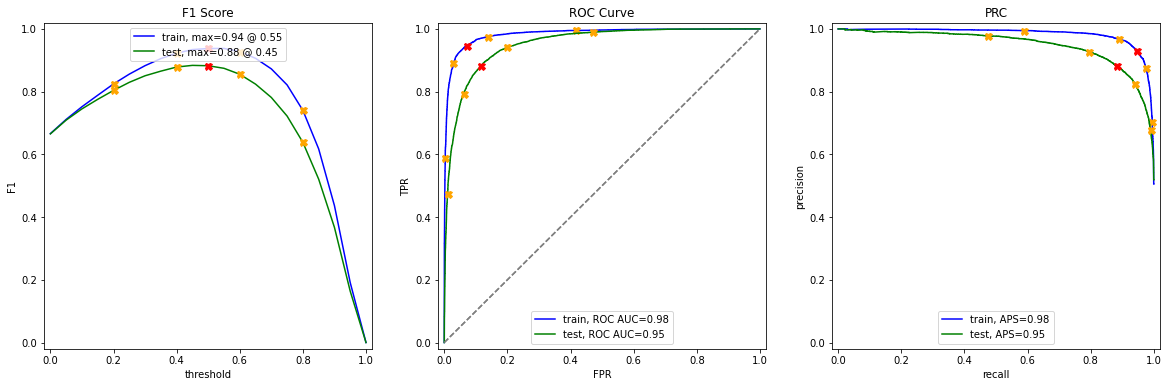

In [75]:
evaluate_model(final_model, train_preprocessed, train_target, test_preprocessed, test_target)

The final model F1 score for the train set equals 0.94 and 0.88 for the test set; the model is pretty precise, with average precision score of 0.95, while its accuracy and recall score 0.88.

[Back to Content](#content)

### My Reviews

Let's illustarte how the chosen model processes custom made reviews.

In [76]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'Writers really cared about the source material, I didn\'t expect the reboot to be so good!',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

We will apply the same vectorization logic as for the final model:

In [77]:
my_reviews['review_clean']= my_reviews['review'].apply(lambda x: clear_text(x))

In [78]:
texts = preprocessing.transform(my_reviews['review_clean'])

In [79]:
my_reviews_pred_prob = final_model.predict_proba(texts)[:, 1]

for i, review in enumerate(my_reviews['review_clean'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.31:  writers really cared about the source material i didn't expect the reboot to be so good
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The probabilities look reasonable.

## Summary and conclusions<a id='conclusions'></a>

At the data uploading and exploration step of the project, we:
- uploaded the relevant set of the source data, with 47331 observations equally divided into train and test subsets; no missing values and no duplicates were observed;
- explored the distributions of the target variable and revealed the similarity between the train and the test data subsets;
- cleaned the feature, `review`, column from digits, punctuation and other signs, and transformed the column into lower case.

In this project, we considered several methods of text data vectorization:
- simple bag-of-words on cleaned text data,
- TF-IDF weighted bag-of-words,
- lemmatization of cleaned text data with the `spacy` library before TF-IDF weightening,
- extracting BERT embeddings.

We applied two types of ML classification models:
- Logistic Regression,
- LightGBM Classifier.

For model selection we applied cross validation technique on the train data subset; additionaly, we tried best model parameter search with `GridSearchCV()` for the Logistic Regression model, while focusing mainly on the `C` parameter of inverse of regularization strength.

The study revealed that a basic Logistic Regression model, applied to TF-IDF weighted bag-of-words for cleaned text data, scores the best; on the test data subset the model showed F1 score, precision and recall equal to 0.88, while the accuracy of the model reached 0.95. We applied the model to a set of custom-made reviews, to illustrate the probabilities which the model assignes to the reviews to be positive.